# Demo for integrating robust GD into neural net backprop

This is the main notebook for the companion repository to our tutorial paper <a href="https://feedbackward.com/content/chainrob.pdf">Robust gradient descent via back-propagation: A Chainer-based tutorial</a>.

#### Contents:

1. <a href="#simple_ex">Implementing our first example</a>

1. <a href="#demo_iris_noisyinputs">A complete demo: Iris data with noisy inputs</a>

   1. <a href="#demo_iris_noisyinputs_dataset">Prepare the data set</a>
   
   1. <a href="#demo_iris_noisyinputs_runalgo">Try out the learning algorithm(s)</a>
   
   1. <a href="#demo_iris_noisyinputs_perf">Visualization of learning efficiency</a>

___

<a id="simple_ex"></a>
## Implementing our first example

In [1]:
import chainer.computational_graph as cg
import chainer.functions as cfn
import chainer as ch
import numpy as np

In [2]:
# Step by step forward computations.
x1 = ch.Variable(np.array([1.5], dtype=np.float32))
x2 = ch.Variable(np.array([3.0], dtype=np.float32))
u1 = x1**3
u2 = x1*x2
u3 = u1/x2
u4 = cfn.sin(u2)
u5 = u3+u4

In [3]:
g = cg.build_computational_graph([u5])
with open("simple_ex_cpgraph.dot", "w") as o:
    o.write(g.dump())

In [4]:
! dot -Tpdf simple_ex_cpgraph.dot -o simple_ex_cpgraph.pdf
! dot -Tpng simple_ex_cpgraph.dot -o simple_ex_cpgraph.png

See the computational graph below (refresh browser if required):

 <img src="simple_ex_cpgraph.png" alt="computational graph" width="350">


Compute $\bar{u}_{i}$ and $\bar{x}_{i}$ quantities manually:

In [5]:
# Reverse mode computations (by hand)
ub5 = ch.Variable(np.array([1.0], dtype=np.float32))
ub4 = ub5
ub3 = ub5
ub2 = ub4*cfn.cos(u2)
ub1 = ub3/x2
xb2 = -ub3*u1/x2**2 + ub2*x1
xb1 = ub2*x2 + ub1*3*x1**2

Now use Chainer to compute the same quantities automatically:

In [6]:
# Reverse mode computations (by Chainer)
u5.backward(retain_grad=True)

Finally, compare the outputs:

In [7]:
print("ub5 = {:5.4f} vs. u5.grad = {:5.4f}".format(ub5.data[0],u5.grad[0]))
print("ub4 = {:5.4f} vs. u4.grad = {:5.4f}".format(ub4.data[0],u4.grad[0]))
print("ub3 = {:5.4f} vs. u3.grad = {:5.4f}".format(ub3.data[0],u3.grad[0]))
print("ub2 = {:5.4f} vs. u2.grad = {:5.4f}".format(ub2.data[0],u2.grad[0]))
print("ub1 = {:5.4f} vs. u1.grad = {:5.4f}".format(ub1.data[0],u1.grad[0]))
print("xb2 = {:5.4f} vs. x2.grad = {:5.4f}".format(xb2.data[0],x2.grad[0]))
print("xb1 = {:5.4f} vs. x1.grad = {:5.4f}".format(xb1.data[0],x1.grad[0]))

ub5 = 1.0000 vs. u5.grad = 1.0000
ub4 = 1.0000 vs. u4.grad = 1.0000
ub3 = 1.0000 vs. u3.grad = 1.0000
ub2 = -0.2108 vs. u2.grad = -0.2108
ub1 = 0.3333 vs. u1.grad = 0.3333
xb2 = -0.6912 vs. x2.grad = -0.6912
xb1 = 1.6176 vs. x1.grad = 1.6176


___

<a id="demo_iris_noisyinputs"></a>
## A complete demo: Iris data with noisy inputs

<a id="demo_iris_noisyinputs_dataset"></a>
### Prepare the data set

First we acquire the famous <a href="https://archive.ics.uci.edu/ml/datasets/iris">Iris Data Set</a> due to R.A. Fisher, included in the UCI Machine Learning Respository. We shall store the data in a directory called `data`.

In [8]:
! mkdir -p data
! mkdir -p data/iris

In [9]:
! wget -nc https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data -P data/iris/
! wget -nc https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.names -P data/iris/

--2019-04-09 09:33:08--  https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4551 (4.4K) [application/x-httpd-php]
Saving to: ‘data/iris/iris.data’

iris.data           100%[===================>]   4.44K  --.-KB/s    in 0s      

2019-04-09 09:33:08 (48.4 MB/s) - ‘data/iris/iris.data’ saved [4551/4551]

--2019-04-09 09:33:08--  https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.names
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2998 (2.9K) [application/x-httpd-php]
Saving to: ‘data/iris/iris.names’

iris.names          100%[===================>]   2.93K  --.-KB/s    in 0

Next we organize a few basic facts about the dataset, chiefly for clerical purposes.

In [10]:
# Clerical stuff.
_n = 150
_n_tr = 100
_n_te = _n - _n_tr
_nf = 4 # number of features to start.
_nc = 3 # number of classes.
_label_dict = {"Iris-setosa": 0,
               "Iris-versicolor": 1,
               "Iris-virginica": 2}

Beware that this `iris.data` file contains one more line than is required (since there should be only 150 points). The 151st line is blank, and so we can just skip it.

In [11]:
! wc -l data/iris/iris.data

151 data/iris/iris.data


Next we use the `csv` module to read the text file and convert the data into a `numpy` array.

In [12]:
import os
import csv
import numpy as np
from sklearn.decomposition import PCA

toread = os.path.join("data", "iris", "iris.data")

X = np.zeros((_n,_nf), dtype=np.float32)
y = np.zeros((_n,1), dtype=np.int8)

with open(toread, newline="") as f_table:
    
    f_reader = csv.reader(f_table, delimiter=",")
    
    i = 0
    for line in f_reader:
        X[i,:] = np.array(line[0:-1],
                          dtype=X.dtype)
        y[i,:] = np.array(_label_dict[line[-1]],
                          dtype=y.dtype)
        i += 1
        
        if i >= _n: # to skip the final blank line.
            break
        

In [13]:
# Shuffle up the data set (+ PCA dim reduction).
my_pca = PCA(n_components=2, whiten=True) # PCA setup.
shufidx = np.random.choice(X.shape[0], size=X.shape[0], replace=False)
X = my_pca.fit_transform(X[shufidx,:]) # PCA mapping.
y = y[shufidx,:]

In [14]:
# Normalize the inputs in a per-feature manner (as max/min are vecs).
maxvec = np.max(X, axis=0)
minvec = np.min(X, axis=0)
X = X-minvec
with np.errstate(divide="ignore", invalid="ignore"):
    X = X / (maxvec-minvec)
    X[X == np.inf] = 0
    X = np.nan_to_num(X)

This ends our preparation of the dimension-reduced dataset; random perturbations to the inputs will be done at runtime.

<a id="demo_iris_noisyinputs_runalgo"></a>
### Try out the learning algorithm(s)

Let us call the demonstration experiment here `iris_noisyinputs`. We make a directory for saving results.

In [15]:
import math
import chainer as ch
import get_model as gm
import helpers as hlp
import robustify as rob

# Prepare a results directory.
_task_name = "iris_noisyinputs"
towrite = os.path.join("results", _task_name)
hlp.makedir_safe(dirname=towrite)

# Data modification parameters.
_rad_factor = 1e+4   # coefficient controlling how far to push data.
_frac_to_move = 0.02 # the fraction of the training data to perturb.

In [16]:
# Model/algorithm parameters.
_num_trials = 20
_t_max = 1000
_num_records = 1000+1 # number of times to record performance.
_lr = 0.5             # learning rate for steepest descent type of update.
_num_units = 10       # number of units in each hidden layer.
_robfn = rob.softmean # specification of robustifier.
_todiv = _t_max // (_num_records-1)
_mod_names = ["deep", "deep-rob"]
_paras = {"num_units": _num_units,
          "robfn": _robfn}

In [17]:
# Main loop over methods.

for mod_name in _mod_names:
    
    print("Working on {}...".format(mod_name))
    
    # Prepare storage for performance metrics.
    loss_tr = np.zeros((_num_trials,_num_records), dtype=np.float32)
    loss_te = np.zeros((_num_trials,_num_records), dtype=np.float32)
    costs = np.zeros((_num_records,), dtype=np.uint32)
    
    for tri in range(_num_trials):
        
        if tri % 10 == 0:
            print("Trial number {}.".format(tri))
        
        cost_counter = 0
    
        shufidx = np.random.choice(_n, size=_n, replace=False)
        X_tr = X[shufidx[0:_n_tr],:]
        y_tr = y[shufidx[0:_n_tr],:]
        X_te = X[shufidx[_n_tr:],:]
        y_te = y[shufidx[_n_tr:],:]
        
        # Add input noise randomly.
        x_center = np.mean(X_tr, axis=0)
        x_sd = np.std(
            np.sqrt(np.sum((X_tr-x_center)**2, axis=1))
        )
        idx_to_move = np.random.choice(_n_tr,
                                       size=math.ceil(_frac_to_move*_n_tr),
                                       replace=False)
        r_noise = _rad_factor * x_sd
        for i in idx_to_move:
            x_pre = X_tr[i,:]
            r_ratio = r_noise / np.sqrt(np.sum((x_pre-x_center)**2))
            X_tr[i,:] = -x_pre*r_ratio + (1+r_ratio)*x_center
        
        # Preparation of model and optimizer objects.
        mod = gm.get_model(mod_name=mod_name,
                           nf=X.shape[1], nc=_nc,
                           paras=_paras)
        opt = ch.optimizers.SGD(lr=_lr)
        opt.setup(mod)
        
        # Finally, run the learning algorithm for the initialized models.
        tval = 0
        idx = 0
        while tval < _t_max:

            # Evaluate current state.
            loss = ch.functions.softmax_cross_entropy(
                x=mod(X_tr),
                t=y_tr.flatten(),
                normalize=True,
                reduce="mean"
            )

            # Get gradients.
            mod.cleargrads()
            loss.backward()

            # Parameter update.
            opt.update()

            # Cost update (assumes gradient descent using full batch).
            if tri == 0:
                cost_counter += X_tr.shape[0]

            # Record performance for the given iteration.
            if tval % _todiv == 0:
                
                if tri == 0:
                    costs[idx] = cost_counter
                
                acc_tr = ch.functions.accuracy(y=mod(X_tr),
                                               t=y_tr.flatten()).data
                acc_te = ch.functions.accuracy(y=mod(X_te),
                                               t=y_te.flatten()).data
                loss_tr[tri,idx] = 1.0-acc_tr
                loss_te[tri,idx] = 1.0-acc_te
                    
                idx += 1

            tval += 1
        
        # Record final performance if not done so already.
        if idx < _num_records:
            
            if tri == 0:
                costs[idx] = cost_counter
            
            acc_tr = ch.functions.accuracy(y=mod(X_tr),
                                           t=y_tr.flatten()).data
            acc_te = ch.functions.accuracy(y=mod(X_te),
                                           t=y_te.flatten()).data
            loss_tr[tri,idx] = 1.0-acc_tr
            loss_te[tri,idx] = 1.0-acc_te
            
            idx += 1
    
    # After running all trials, take stats and arrange into perf mtx.
    ave_loss_tr = np.mean(loss_tr, axis=0)
    ave_loss_te = np.mean(loss_te, axis=0)
    ave_loss = np.vstack((ave_loss_tr,ave_loss_te)).T # transpose it.

    # Write to disk.
    np.savetxt(fname=os.path.join(towrite, (mod_name+".ave")),
               X=ave_loss, fmt="%.7e", delimiter=",")
    np.savetxt(fname=os.path.join(towrite, (mod_name+".cost")),
               X=costs, fmt="%d", delimiter=",")
    
    del mod, opt
    
    print("Done.")

Working on deep...
Trial number 0.
Trial number 10.
Done.
Working on deep-rob...
Trial number 0.
Trial number 10.
Done.


<a id="demo_iris_noisyinputs_perf"></a>
### Visualization of learning efficiency

In [18]:
import numpy as np
import os
import matplotlib.pyplot as plt

_fontsize = "xx-large"
_task_name = "iris_noisyinputs"
_mth_names = ["deep", "deep-rob"]
_mth_colors = ["black", "blue"]
_mth_markers = ["-", "-"]

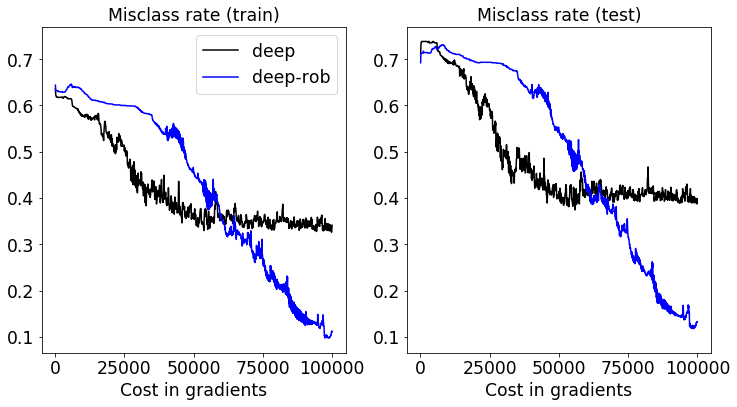

In [19]:
myfig = plt.figure(figsize=(12,6))

perf_idx = 0
ax1 = myfig.add_subplot(1,2,1)
for i in range(len(_mth_names)):
    
    mth_name = _mth_names[i]
    mth_color = _mth_colors[i]
    
    toread = os.path.join("results", _task_name)
    
    # Read in all relevant performance.
    with open(os.path.join(toread, (mth_name+".ave")), mode="r", encoding="ascii") as f:
        tmp_ave = np.loadtxt(fname=f, dtype=np.float, usecols=perf_idx, delimiter=",")
            
    with open(os.path.join(toread, (mth_name+".cost")), mode="r", encoding="ascii") as f:
        tmp_cost = np.loadtxt(fname=f, dtype=np.uint, delimiter=",")
    
    ax1.plot(tmp_cost, tmp_ave, _mth_markers[i],
             color=mth_color,
             label=mth_name) # option: semilogy with basey=10.
    ax1.tick_params(labelsize=_fontsize)

ax1.legend(loc="best",ncol=1, fontsize=_fontsize)
plt.title("Misclass rate (train)", size=_fontsize)
plt.xlabel("Cost in gradients", size=_fontsize)

perf_idx = 1
ax2 = myfig.add_subplot(1,2,2, sharey=ax1)
for i in range(len(_mth_names)):
    
    mth_name = _mth_names[i]
    mth_color = _mth_colors[i]
    
    #print("Performance evaluation:", mth_name)
    
    toread = os.path.join("results", _task_name)
    
    # Read in all relevant performance.
    with open(os.path.join(toread, (mth_name+".ave")), mode="r", encoding="ascii") as f:
        tmp_ave = np.loadtxt(fname=f, dtype=np.float, usecols=perf_idx, delimiter=",")
            
    with open(os.path.join(toread, (mth_name+".cost")), mode="r", encoding="ascii") as f:
        tmp_cost = np.loadtxt(fname=f, dtype=np.uint, delimiter=",")
    
    ax2.plot(tmp_cost, tmp_ave, _mth_markers[i],
             color=mth_color,
             label=mth_name)# option: semilogy with basey=10.
    ax2.tick_params(labelsize=_fontsize)

plt.title("Misclass rate (test)", size=_fontsize)
plt.xlabel("Cost in gradients", size=_fontsize)

plt.savefig(fname="results_iris_noisyinputs.pdf", bbox_inches="tight")

plt.show()

___